In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using Ipopt
using StaticArrays
using TrajectoryOptimization
using Altro
using RobotDynamics
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`


In [2]:
# TODO: Leaning back and forth: do that to test
# Add a torque going around the pitch and roll input
# 3 inputs + the contact forces
# 12 dimensional 

## 3D Hopper

The 3D hopper is composed of a prismatic joint and (two?) revolute joint(s), and makes the assumption that torque effects are equal and opposite at the head and foot. An image is shown below (copy that image in when you have time). It is parameterized by the following:  

$$ x = \begin{bmatrix} 
        x_{head} \\
        y_{head} \\
        z_{head} \\
        x_{foot} \\
        y_{foot} \\
        z_{foot} \\
        \dot x_{head} \\
        \dot y_{head} \\
        \dot z_{head} \\
        \dot x_{foot} \\
        \dot y_{foot} \\
        \dot z_{foot} \\
       \end{bmatrix} $$
        
$$ u = \begin{bmatrix}
        F_{pris} \\
        F_{pitch} \\
        F_{roll} \\
        F_{x, contact} \\
        F_{y, contact} \\
        F_{z, contact} \\
       \end{bmatrix} $$

In [10]:
# 2D Hopper, parameterized by the following:

function dynamics_3d(x, u)
    # x is a 12-dimensional vector, u is a 6-dimensional vector
    mh = 2.0
    mf = 1.0
    l = 1.0
    g = 9.81
    states = 12
    controls = 6
    v = x[7:states]
    
    
    # TODO: determine what Jx, Jy, Jz are 
    headVec = x[1:3]
    footVec = x[4:6]
    
    bodyDirec = (headVec .- footVec) ./ norm(headVec .- footVec)
    xHat = bodyDirec[1]
    yHat = bodyDirec[2]
    zHat = bodyDirec[3]
    
    # cosTh = (headVec[1] - footVec[1]) / norm(headVec - footVec)
    # sinTh = (headVec[3] - footVec[3]) / norm(headVec - footVec)
    
    J = u[1]
    pitch = u[2]
    roll = u[3]
    λx = u[4]
    λy = u[5]
    λz = u[6]
    
    Jx, Jy, Jz = J .* bodyDirec
    
    axh = (Jx + pitch*zHat)/mh
    ayh = (Jy - roll*zHat)/mh
    azh = (Jz - pitch*xHat + roll*yHat - mh*g)/mh
    axf = (λx - Jx - pitch*zHat)/mf
    ayf = (λy - Jy + roll*zHat)/mf
    azf = (λz - Jz + pitch*xHat - roll*yHat - mf*g)/mf
    
    return [v; axh; ayh; azh; axf; ayf; azf]
end


function dynamics_3d_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_3d(x, u)
    f2 = dynamics_3d(x + 0.5*h*f1, u)
    f3 = dynamics_3d(x + 0.5*h*f2, u)
    f4 = dynamics_3d(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end


struct Hopper <: AbstractModel end
RobotDynamics.state_dim(::Hopper) = 12
RobotDynamics.control_dim(::Hopper) = 6


function RobotDynamics.dynamics(::Hopper,x,u)
    ẋ = dynamics_3d(x, u)
end


In [13]:
# Initialize the visualizer
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [5]:
function kinematics(x)
    return [x[1], x[2]]
end

function visualize!(vis, Xs, h)
    r_body = 0.2
    r_foot = 0.1
    r_leg = 0.5*r_foot
    
    setvisible!(vis["/Background"], true)
    headSphere = Sphere(Point3f0(0), convert(Float32, r_body))
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    legSphere = Sphere(Point3f0(0), convert(Float32, r_leg))
    setobject!(vis["body"], headSphere, MeshPhongMaterial(color = RGBA(1.0, 0.0, 1.0, 1.0)))
    setobject!(vis["foot"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], legSphere, MeshPhongMaterial(color=RGBA(0.0, 0.0, 0.0, 1.0)))
    end
    
    p_leg = [zeros(3) for i = 1:n_leg]
    
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = [x[1], x[2], x[3]]
        p_foot = [x[4], x[5], x[6]]
        
        z_shift = [0.0, 0.0, r_foot]
        
        xDist, yDist, zDist = p_body .- p_foot        
        
        for i = 1:n_leg
            p_leg[i] .= i/n_leg*[xDist, yDist, zDist] .+ p_foot
        end
        
        MeshCat.atframe(anim, t) do 
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))
            
            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
        
    end
    MeshCat.setanimation!(vis, anim)
    
end
            

visualize! (generic function with 1 method)

In [19]:
function stance_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    rows = 4
    A = zeros(rows, n)
    # Pin the foot to the floor, so no velocity in any direction
    A[1, 6] = 1.0
    A[2, 10] = 1.0
    A[3, 11] = 1.0
    A[4, 12] = 1.0
    b = SVector{rows}(zeros(rows))
    return LinearConstraint(n, m, A, b, Equality(), 1:n)
end


function flight_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(3, m)
    # Constrain the contact forces to be 0
    A[1, 4] = 1.0
    A[2, 5] = 1.0
    A[3, 6] = 1.0
    b = SVector{3}(zeros(3))
    return LinearConstraint(n, m, A, b, Equality(), (n+1):(n+m))
end


function friction_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(1, m)
    μ = 0.5
    A[1, 3] = 1.0
    A[1, 4] = -μ
    b = SVector{1}(0.0)
    forward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    
    A = zeros(1, m)
    μ = 0.5
    A[1, 3] = -1.0
    A[1, 4] = -μ
    b = SVector{1}(0.0)
    backward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    return forward, backward
end


function normal_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(1, m)
    A[1, 6] = -1.0
    b = SVector{1}(0.0)
    return LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
end


function bin_mode_list(N, mSteps; iState=1)
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    return modeList
end

function add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, forward, i)
        add_constraint!(conSet, backward, i)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

function add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

add_nf_constraints! (generic function with 1 method)

## Jump northwest


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 23
    Solve Time: 353.9785 (ms)

  Covergence
    Terminal Cost: 6724.728441040108
    Terminal dJ: 0.08701803322310298
    Terminal gradient: 162.81046940279967
    Terminal constraint violation: 5.716402913282872e-7
    Solve Status: SOLVE_SUCCEEDED


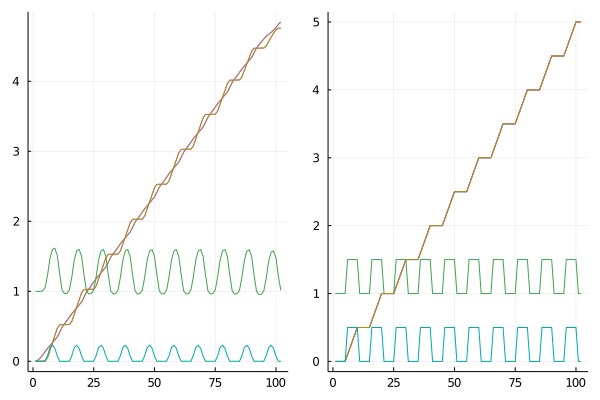

In [14]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 102
    h = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    # modeList[end] = 3
    mh = 2.0
    mf = 1.0
    
    g = 9.81
    ueq = [mh*g, 0.0, 0.0, 0.0, 0.0, (mh+mf)*g]
    currX = zeros(n)
    currX[3] = 1.0
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 200.0 * diagm([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 200.0 * I(n)
    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    
    xShift = 0.1
    yShift = 0.1
    
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[3, i] = 1.0
            xRefSimp[6, i] = 0.0
            xRefSimp[1, i] = xRefSimp[1, i-1]
            xRefSimp[4, i] = xRefSimp[4, i-1]
            xRefSimp[2, i] = xRefSimp[2, i-1]
            xRefSimp[5, i] = xRefSimp[5, i-1]
        else
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[5, i] = xRefSimp[5, i-1] + yShift
        end
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # println(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1))
    
    # Stance constraints
    stnc = stance_constraints_3d(model)
    flgt = flight_constraints_3d(model)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_3d(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    # println(solveU)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Circle hops


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 45
    Solve Time: 652.679399 (ms)

  Covergence
    Terminal Cost: 4555.518729671547
    Terminal dJ: 6.825316813774407e-5
    Terminal gradient: 0.0004846768738641252
    Terminal constraint violation: 0.0006801674411545315
    Solve Status: SOLVE_SUCCEEDED


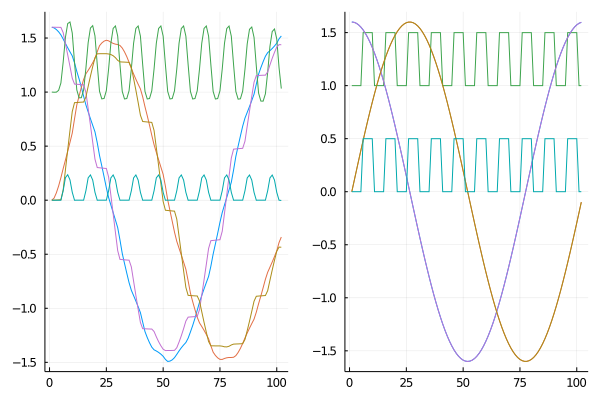

In [15]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 102
    h = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    
    mh = 2.0
    mf = 1.0
    
    g = 9.81
    ueq = [mh*g, 0.0, 0.0, 0.0, 0.0, (mh+mf)*g]
    
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 100.0 * diagm([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 200.0 * I(n)
    R = 0.1 * I(m)
    
    
    # Follow the path of a circle with a certain radius
    r = 1.6
    # equation of a circle is x^2 + y^2 = r^2, so let our dx = 0.1
    currX = zeros(n)
    currX[3] = 1.0
    currX[1] = r
    currX[4] = r
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[3, i] = 1.0
            xRefSimp[6, i] = 0.0
        else
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
        end 
        xRefSimp[1, i] = r*cos(2*pi/N * (i-1))
        xRefSimp[4, i] = r*cos(2*pi/N * (i-1))
        xRefSimp[2, i] = r*sin(2*pi/N * (i-1))
        xRefSimp[5, i] = r*sin(2*pi/N * (i-1))
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # println(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1))
    
    # Stance constraints
    stnc = stance_constraints_3d(model)
    flgt = flight_constraints_3d(model)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_3d(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    # println(solveU)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Back and forth hopping

In [17]:
function step_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    rows = 3
    A = zeros(rows, n)
    # Pin the foot to the floor, so no velocity in any direction
    # A[1, 6] = 1.0
    A[1, 10] = 1.0
    A[2, 11] = 1.0
    A[3, 12] = 1.0
    b = SVector{rows}(zeros(rows))
    return LinearConstraint(n, m, A, b, Equality(), 1:n)
end

function add_step_constraints!(conSet, stnc, flgt, step, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        elseif modeList[i] == 2
            add_constraint!(conSet, flgt, i)
        else
            add_constraint!(conSet, step, i)
        end
    end
end

add_step_constraints! (generic function with 1 method)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006, 2.0000000000000004, 2.0000000000000004, 2.0000000000000004, 2.0000000000000004, 2.0000000000000004, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.500000000000001, 2.500000000000001, 2.500000000000001, 2.500000000000001, 2.500000000000001]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    To

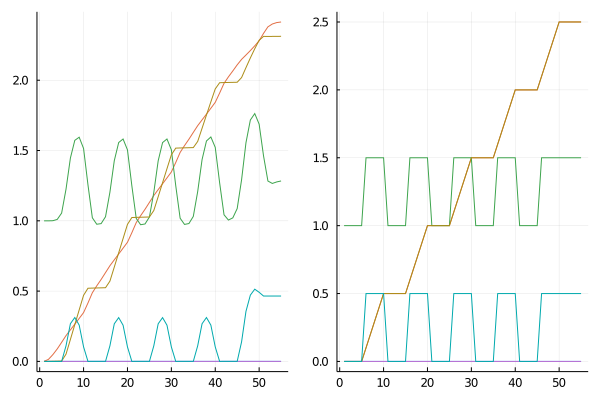

In [22]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 55
    h = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    modeList[end-mSteps+1:end] .= 3
    mh = 2.0
    mf = 1.0
    
    g = 9.81
    ueq = [mh*g, 0.0, 0.0, 0.0, 0.0, (mh+mf)*g]
    currX = zeros(n)
    currX[3] = 1.0
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 200.0 * diagm([1.0, 5.0, 5.0, 1.0, 5.0, 20.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 100.0 * I(n)
    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    
    xShift = 0.0
    yShift = 0.1
    
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[3, i] = 1.0
            xRefSimp[6, i] = 0.0
            xRefSimp[1, i] = xRefSimp[1, i-1]
            xRefSimp[4, i] = xRefSimp[4, i-1]
            xRefSimp[2, i] = xRefSimp[2, i-1]
            xRefSimp[5, i] = xRefSimp[5, i-1]
        elseif modeList[i] == 2
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[5, i] = xRefSimp[5, i-1] + yShift
        else
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
            xRefSimp[1, i] = xRefSimp[1, i-1]
            xRefSimp[4, i] = xRefSimp[4, i-1]
            xRefSimp[2, i] = xRefSimp[2, i-1]
            xRefSimp[5, i] = xRefSimp[5, i-1]
        end 
    end
#     xRefSimp[3, end-2*mSteps+1:end] .= 4.5
#     xRefSimp[6, end-2*mSteps+1:end] .= 3.5
    println(xRefSimp[2, :])
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # println(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1))
    
    # Stance constraints
    stnc = stance_constraints_3d(model)
    flgt = flight_constraints_3d(model)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_3d(model)
    stp = step_constraints_3d(model)
    add_step_constraints!(conSet, stnc, flgt, stp, normal, modeList)
    
    
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    println(modeList)
    box = HyperRectangle(Vec(-0.5, 2.15, 0.0), Vec(1.0, 1.0, 0.5))
    green_material = MeshPhongMaterial(color=RGBA(1, 1, 1, 1.0))
    setobject!(vis, box, green_material)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Backflip

In [11]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 15
    st = 13
    h = 0.1
    mSteps = N
      
    modeList = ones(1, N) * 2.0
    modeList[1] = 1.0
    # modeList[end] = 1.0
    modeList[st:N] .= 1.0
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 2*g]
    currX = [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 50.0 * Diagonal([5.0, 5.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 500.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])

    R = 0.1* I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    uRefSimp = zeros(m, N-1)
    
    xShift = 0.75
    yShift = 0.01
    for i = 2:N
        if i-1 <= st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/4 && i-1 <= st/2
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/2 && i-1 <= 3*st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = -xShift
        elseif i-1 > 3*st/4 && i-1 <= st
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = -xShift
        end
    end
    
    xRefSimp[:, st:end] .= currX

    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    println(solveU)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end

LoadError: UndefVarError: ExtraHopper not defined